In [1]:
import pandas as pd
import numpy as np
import yaml
import sys

sys.path.append('../../')
from dataset import PdaVideos, collate_video
import transforms as my_transforms
from train_pda_cv import evaluate

import models
import timm
import copy
import torch
from torch.utils.data import DataLoader


In [2]:
plt.rcParams['font.size'] = 14

NameError: name 'plt' is not defined

In [ ]:
# artifact_folder = "/project/dane2/wficai/pda/model_run_artifacts/pda_cvtest/"
artifact_folder = '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/'
frame_csv = '/project/dane2/wficai/pda/external_validation/CHOC_echo_images/pda_train_val_test.csv'

split = 'TEST' # 'TEST' or 'VAL' or None. None means val and test set.
CHOC_sensitivity = 0.76 # VAL and TEST happen to be the same

# load config.yaml from the artifact folder
with open(f'{artifact_folder}/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

config['frame_csv'] = frame_csv
config['dataset_kwargs']['mode_filter'] = None
config['dataset_kwargs']['view_filter'] = None
config['dataset_kwargs']['split'] = split

device = torch.device('cuda:0')

In [ ]:
config

{'artifact_folder': '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/',
 'dataloader_kwargs': {'batch_size': 15,
  'num_workers': 20,
  'pin_memory': True},
 'dataset_kwargs': {'mode_filter': None, 'view_filter': None, 'split': None},
 'device': 'cuda:0',
 'early_stopper_kwargs': {'patience': 10},
 'encoder_kwargs': {'checkpoint': None,
  'checkpoint_path': None,
  'in_chans': 3,
  'model_name': 'resnet50d',
  'pretrained': True},
 'frame_csv': '/project/dane2/wficai/pda/external_validation/CHOC_echo_images/pda_train_val_test.csv',
 'num_epochs': 50,
 'optim_kwargs': {'lr': 0.0001, 'weight_decay': 0.001},
 'res': 112,
 'sched_kwargs': {'factor': 0.1, 'patience': 3, 'verbose': True},
 'subset_column': None,
 'time_downsample_kwargs': {'method': 'random', 'num_frames': 32},
 'vidnet_kwargs': {'drop_rate': 0.5,
  'num_heads': 4,
  'num_out': 1,
  'pooling_method': 'attn'}}

In [ ]:
# use glob to get all *.ckpt files from the artifact directory
import glob
ckpt_files = glob.glob(f'{artifact_folder}/*.ckpt')
ckpt_files

['/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_0.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_1.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_10.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_11.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_2.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_3.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_4.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_5.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_6.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_7.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_c

In [ ]:
def create_model(checkpoint):
    # create the model
    encoder = timm.create_model(**config['encoder_kwargs'], num_classes=0)
    m = models.MedVidNet(copy.deepcopy(encoder), **config['vidnet_kwargs']).to(device)
    m.load_state_dict(torch.load(checkpoint, map_location=device))
    
    return m

model_list = torch.nn.ModuleList([create_model(ckpt) for ckpt in ckpt_files])

# define a pytorch model that takes the outputs from all of the models and averages them
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = models
        
    def forward(self, x, num_frames):
        # [0] drops unneeded attention
        outputs = [m(x, num_frames)[0] for m in self.models]
        # none is for compatibility with the evaluate function
        return torch.mean(torch.stack(outputs), dim=0), None
    
ensemble_model = EnsembleModel(model_list).to(device)

In [ ]:
# transforms
tfms = my_transforms.VideoTransforms(config['res'], time_downsample_kwargs = config['time_downsample_kwargs'])
tfms_test = tfms.get_transforms('test')

In [ ]:
# load data
df_frames = pd.read_csv(config['frame_csv'])

# filter to "VAL" and "TEST" splits
df_frames = df_frames[df_frames['Split'].isin(['VAL', 'TEST'])]

# add dummy columns
df_frames['view'] = 'pdaView'
df_frames['mode'] = 'color'
df_frames['study'] = df_frames['patient_id']
df_frames['external_id'] = df_frames['clip_id']
df_frames['cv_split'] = 0

# create dataset
dat = PdaVideos(df_frames, transforms=tfms_test, **config['dataset_kwargs'])
print("Train data size:", len(dat))

Train data size: 146


In [ ]:
dl_val= DataLoader(dat, collate_fn=collate_video, **config['dataloader_kwargs'])

In [ ]:
loss, mets, targets, outputs, external_ids, patient_ids = evaluate(ensemble_model, dl_val, device)

In [ ]:
mets

{'roc_auc': 0.8734984984984986,
 'accuracy': 0.7808219178082192,
 'sensitivity': 0.8333333333333334,
 'specificity': 0.7297297297297297}

Threshold: 0.427


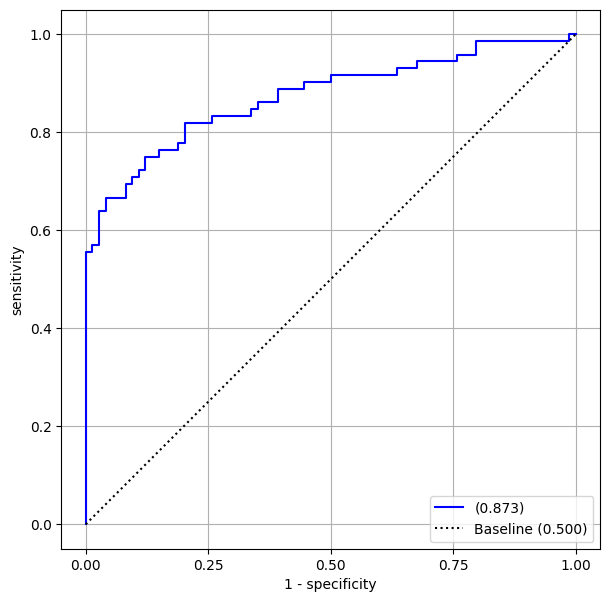

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# create a roc curve
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targets.astype(int), outputs)
score = roc_auc_score(targets.astype(int), outputs)

# find the threshold such that sensitivity ~= Choc value of 0.76 (validation set)
idx = np.argmin(np.abs(tpr - CHOC_sensitivity))
decision_threshold = eps[idx]
print(f"Threshold: {decision_threshold:0.3f}")

plt.plot(fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.plot(grid, grid, 'k:', label='Baseline (0.500)')
plt.gca().set_aspect(1)
plt.legend(loc=4)
plt.grid()

plt.xlabel("1 - specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22

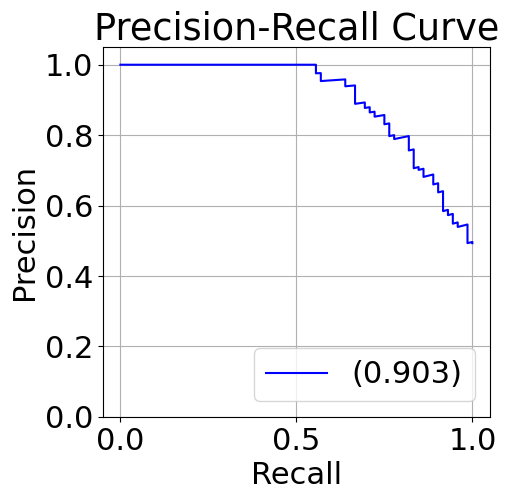

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# create a prec-rec curve
precision, recall, thresholds = precision_recall_curve(targets.astype(int), outputs)
ap = average_precision_score(targets.astype(int), outputs)

plt.plot(recall, precision, 'b-', label=f"({ap:0.3f})")
plt.ylim(0,1.05)
plt.gca().set_aspect(1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc=4)
plt.show()


In [ ]:
# sensitivity and specificity at max f1
from sklearn.metrics import confusion_matrix
y_pred = outputs >= decision_threshold
y_true = targets.astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() 

sensitivity = tp / (tp + fn) # true positives / positives
specificity = tn / (tn + fp) # true negatives / negatives
ppv = tp / (tp + fp) # true positives / predicted positives
npv = tn / (tn + fn) # true negatives / predicted negatives

sensitivity, specificity, ppv, npv


(0.7638888888888888, 0.8513513513513513, 0.8333333333333334, 0.7875)

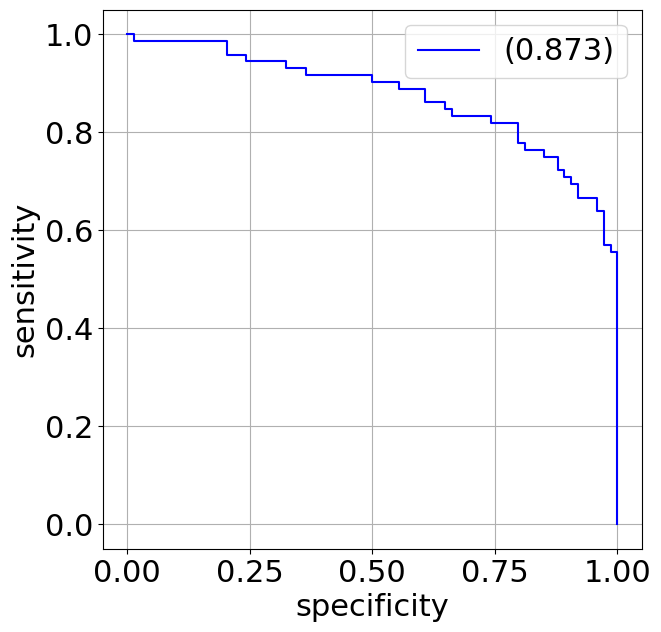

In [ ]:
# sensitivity vs. specificity
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targets.astype(int), outputs)
score = roc_auc_score(targets.astype(int), outputs)

plt.plot(1-fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.gca().set_aspect(1)
plt.legend(loc=1)
plt.grid()

plt.xlabel("specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22